# TCR hackaton

This notebook details the (cleaned & extended) results from the TCR hackaton at the ReBootCamp 2016.

The following changes were made compared to the results presented during the ReBootCamp:
* **Important:** Robust input reading. One file uses a *tab* to separate the different fields, while another file uses a *tab + a space*. Initially I only split fields on a tab, which resulted in a duplication of different `pre` and `post` fields compared to the current version; i.e. `2` and `2_` (two + space) were two different fields. Fixing this bug resulted in a significant decrease (AUC ~0.10) in classification performance. This makes sense, as the usage of a space in one file caused information leakage about the class.
(I wonder if the other groups noticed this and took this into account, or whether it influenced their results as well?)
* Additional features based on the positions of individual amino acids in the peptide sequences.
* Evaluation of training performance in terms of the data size.
* Various small code optimizations and improvements.

In [1]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython import display
from pyteomics import electrochem, mass, parser
from sklearn import cross_validation, ensemble, feature_extraction, learning_curve, metrics

## Individual amino acid features

The following constants were used for the basicity, hydrophobicity, and helicity of individual amino acids, as retrieved from MS2PIP (supplementary table 1) [Degroeve2013].

The substitution values were derived by Bart; I am unclear about how he derived a single value for each amino acid from a substitution matrix.

[Degroeve2013] Degroeve, S. & Martens, L. MS2PIP: A tool for MS/MS peak intensity prediction. *Bioinformatics* **29**, 3199–3203 (2013).

In [2]:
# individual amino acid features
basicity = {'A': 206.4, 'B': 210.7, 'C': 206.2, 'D': 208.6, 'E': 215.6, 'F': 212.1, 'G': 202.7, 'H': 223.7,
            'I': 210.8, 'K': 221.8, 'L': 209.6, 'M': 213.3, 'N': 212.8, 'P': 214.4, 'Q': 214.2, 'R': 237.0,
            'S': 207.6, 'T': 211.7, 'V': 208.7, 'W': 216.1, 'X': 210.2, 'Y': 213.1, 'Z': 214.9}

hydrophobicity = {'A': 0.16, 'B': -3.14, 'C': 2.50, 'D': -2.49, 'E': -1.50, 'F': 5.00, 'G': -3.31, 'H': -4.63,
                  'I': 4.41, 'K': -5.00, 'L': 4.76, 'M': 3.23, 'N': -3.79, 'P': -4.92, 'Q': -2.76, 'R': -2.77,
                  'S': -2.85, 'T': -1.08, 'V': 3.02, 'W': 4.88, 'X': 4.59, 'Y': 2.00, 'Z': -2.13}

helicity = {'A': 1.24, 'B': 0.92, 'C': 0.79, 'D': 0.89, 'E': 0.85, 'F': 1.26, 'G': 1.15, 'H': 0.97,
            'I': 1.29, 'K': 0.88, 'L': 1.28, 'M': 1.22, 'N': 0.94, 'P': 0.57, 'Q': 0.96, 'R': 0.95,
            'S': 1.00, 'T': 1.09, 'V': 1.27, 'W': 1.07, 'X': 1.29, 'Y': 1.11, 'Z': 0.91}

substitution = {'A': 13, 'C': 52, 'D': 11, 'E': 12, 'F': 32, 'G': 27, 'H': 15, 'I': 10, 'K': 24, 'L': 34,
                'M': 6, 'N': 6, 'P': 20, 'Q': 10, 'R': 17, 'S': 10, 'T': 11, 'V': 17, 'W': 55, 'Y': 31}

## Data input

In [3]:
# read and merge the data from the two separate classes
temp_0 = pd.read_csv('data/EI.txt', names=['pre', 'sequence', 'post'], delim_whitespace=True)
temp_0['class'] = 0
temp_1 = pd.read_csv('data/FL.txt', names=['pre', 'sequence', 'post'], delim_whitespace=True)
temp_1['class'] = 1
data = pd.concat([temp_0, temp_1], ignore_index=True)

## Feature generation

Various features were constructed:
* The prefix and postfix categorical attributes were one-hot encoded. This is useful because most classification algorithms are not able to deal with categorical features but require numerical features instead.
* The sequence length (computed by [Pyteomics](https://pythonhosted.org/pyteomics/) [Goloborodko2013], modX notation allowed).
* The number of times each amino acid occurs in the sequence.
* The average of the chemical properties (basicity, hydrophobicity, helicity) and the substitution of the individual amino acids in the sequence, normalized by the sequence length.
* The pI of the full sequence (computed by [Pyteomics](https://pythonhosted.org/pyteomics/)).
* The peptide mass (computed by [Pyteomics](https://pythonhosted.org/pyteomics/)).
* Individual features of each amino acid at specific positions in the sequences:
    * For sequences with an odd length, the center amino acid is assigned index `0`, with ascending indices to the right and descending indices to the left. For sequences with an even length there is no `0` index, but the center two amino acids have index `-1` and `1`.
    There is still a difference in interpretation between the outermost indices, which is unavoidable while dealing with sequences of differing lengths. However, the most important amino acids are in the center, which should have similar indices. Note though that this is not directly comparable between sequences with an odd and even length. This needs some further consideration to make the indices represent similar information, or either the model needs to be explicitly split up between these two cases (not preferred).
    * For each position the following features are generated: which amino acid occurs at this position; the basicity, hydrophobicity, helicity, pI, and substitution value for the amino acid at this position.
    
In total this results in 406 different features for each sequence.

[Goloborodko2013] Goloborodko, A. A., Levitsky, L. I., Ivanov, M. V. & Gorshkov, M. V. Pyteomics-a Python framework for exploratory data analysis and rapid software prototyping in proteomics. *Journal of The American Society for Mass Spectrometry* **24**, 301–304 (2013).

In [4]:
# feature conversion and generation
features_list = []

# one-hot encoding of pre and post
onehot_encoder = feature_extraction.DictVectorizer(sparse=False)
features_list.append(pd.DataFrame(onehot_encoder.fit_transform(data[['pre', 'post']].to_dict(orient='records')),
                                  columns=onehot_encoder.feature_names_))

# sequence length (modX notation allowed)
features_list.append(data['sequence'].apply(lambda sequence: parser.length(sequence)).to_frame().rename(columns={'sequence': 'length'}))

# number of occurences of each amino acid
aa_counts = pd.DataFrame.from_records(
    [parser.amino_acid_composition(sequence) for sequence in data['sequence']]).fillna(0)
aa_counts.columns = ['count_{}'.format(column) for column in aa_counts.columns]
features_list.append(aa_counts)

# chemical properties: (average) basicity, (average) hydrophobicity, (average) helicity, pI
features_list.append(data['sequence'].apply(
        lambda sequence: sum([basicity[aa] for aa in sequence]) / parser.length(sequence))
                     .to_frame().rename(columns={'sequence': 'avg_basicity'}))
features_list.append(data['sequence'].apply(
        lambda sequence: sum([hydrophobicity[aa] for aa in sequence]) / parser.length(sequence))
                     .to_frame().rename(columns={'sequence': 'avg_hydrophobicity'}))
features_list.append(data['sequence'].apply(
        lambda sequence: sum([helicity[aa] for aa in sequence]) / parser.length(sequence))
                     .to_frame().rename(columns={'sequence': 'avg_helicity'}))
features_list.append(data['sequence'].apply(
        lambda sequence: electrochem.pI(sequence)).to_frame().rename(columns={'sequence': 'pI'}))

# substitution values
features_list.append(data['sequence'].apply(
        lambda sequence: sum([substitution[aa] for aa in sequence]) / parser.length(sequence))
                     .to_frame().rename(columns={'sequence': 'avg_substitution'}))

# peptide mass
features_list.append(data['sequence'].apply(
        lambda sequence: mass.fast_mass(sequence)).to_frame().rename(columns={'sequence': 'mass'}))

# positional features
# amino acid occurence and chemical properties at a given position from the center
pos_aa, pos_basicity, pos_hydrophobicity, pos_helicity, pos_pI, pos_substitution = [], [], [], [], [], []
for sequence in data['sequence']:
    length = parser.length(sequence)
    start_pos = -1 * length // 2
    
    pos_aa.append({'pos_{}_{}'.format(start_pos + i, sequence[i]): 1 for i in range(length)})
    pos_basicity.append({'pos_{}_basicity'.format(start_pos + i): basicity[sequence[i]] for i in range(length)})
    pos_hydrophobicity.append({'pos_{}_hydrophobicity'.format(start_pos + i): hydrophobicity[sequence[i]] for i in range(length)})
    pos_helicity.append({'pos_{}_helicity'.format(start_pos + i): helicity[sequence[i]] for i in range(length)})
    pos_pI.append({'pos_{}_pI'.format(start_pos + i): electrochem.pI(sequence[i]) for i in range(length)})
    pos_substitution.append({'pos_{}_substitution'.format(start_pos + i): substitution[sequence[i]] for i in range(length)})

features_list.append(pd.DataFrame.from_records(pos_aa).fillna(0))
features_list.append(pd.DataFrame.from_records(pos_basicity).fillna(0))
features_list.append(pd.DataFrame.from_records(pos_hydrophobicity).fillna(0))
features_list.append(pd.DataFrame.from_records(pos_helicity).fillna(0))
features_list.append(pd.DataFrame.from_records(pos_pI).fillna(0))
features_list.append(pd.DataFrame.from_records(pos_substitution).fillna(0))

# combine all features_list
features = pd.concat(features_list, axis=1)

## Classification

Using these generated features we will train a classifier. For now I have simply used a random forest classifier because of its good performance out of the box [Caruana2008]. All hyperparameters were left at their default values, with the exception of the number of trees which was increased to `1000` to be able to capture more variability among the large set of features.

The data set was split into a stratified 80-20% training and testing set.

As shown below, the classification performance is somewhat less than presented during the ReBootCamp, mainly due to the information leakage issue that was present previously.

[Caruana2008] Caruana, R., Karampatziakis, N. & Yessenalina, A. An empirical evaluation of supervised learning in high dimensions. in *Proceedings of the 25th International Conference on Machine Learning - ICML ’08* 96–103 (ACM Press, 2008).

In [5]:
# train a classifier
X = features.values
y = data['class'].values

# do multiple splits to get a more accurate evaluation of the performance
sss = cross_validation.StratifiedShuffleSplit(y, n_iter=100, test_size=0.2, random_state=0)
predictions, predictions_proba = [], []
for train_index, test_index in sss:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # train the random forest classifier
    classifier = ensemble.RandomForestClassifier(1000, n_jobs=-1, random_state=0)
    classifier.fit(X_train, y_train)
    
    # store predictions for future performance evaluation
    predictions.append((y_test, classifier.predict(X_test)))
    predictions_proba.append((y_test, classifier.predict_proba(X_test)[:, 1]))

Classification accuracy = 78.85% ± 5.01%


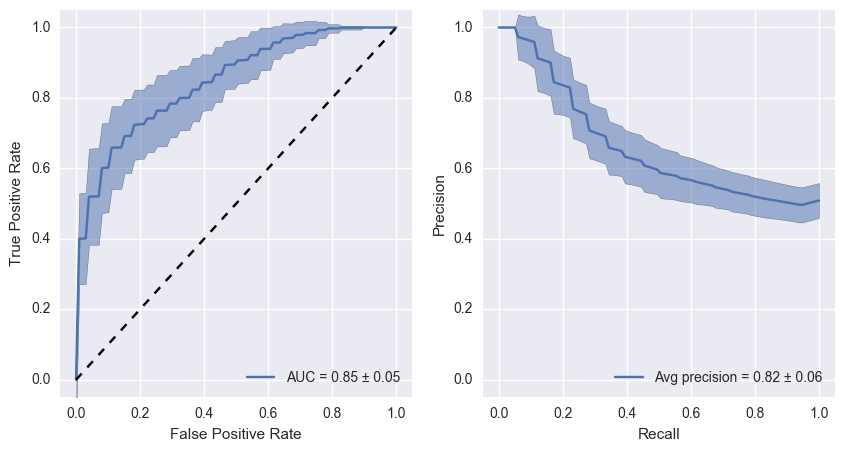

In [6]:
# accuracy
accuracy_mean = np.mean([metrics.accuracy_score(y_test, y_pred) for y_test, y_pred in predictions])
accuracy_std = np.std([metrics.accuracy_score(y_test, y_pred) for y_test, y_pred in predictions])

# AUC and average precision
auc_mean = np.mean([metrics.roc_auc_score(y_test, y_pred) for y_test, y_pred in predictions_proba])
auc_std = np.std([metrics.roc_auc_score(y_test, y_pred) for y_test, y_pred in predictions_proba])
avg_precision_mean = np.mean([metrics.average_precision_score(y_test, y_pred) for y_test, y_pred in predictions_proba])
avg_precision_std = np.std([metrics.average_precision_score(y_test, y_pred) for y_test, y_pred in predictions_proba])

# mean and standard deviation of ROC and precision-recall curves
interval = np.linspace(0, 1, 100)
tprs, precisions = [], []
for y_test, y_pred in predictions_proba:
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    tprs.append(np.interp(interval, fpr, tpr))
    
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
    precisions.append(np.interp(interval, recall[::-1], precision))
tpr_mean = np.mean(tprs, axis=0)
tpr_mean[0], tpr_mean[-1] = 0.0, 1.0
tpr_std = np.std(tprs, axis=0)
precision_mean = np.mean(precisions, axis=0)
precision_std = np.std(precisions, axis=0)

# print accuracy
print('Classification accuracy = {:.2%} ± {:.2%}'.format(accuracy_mean, accuracy_std))

plt.figure(figsize=(10, 5))

# plot ROC curve
plt.subplot(121)

plt.plot(interval, tpr_mean, label='AUC = {:.2f} ± {:.2f}'.format(auc_mean, auc_std))
plt.fill_between(interval, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.5)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc='lower right')

# plot precision-recall curve
plt.subplot(122)

plt.plot(interval[::-1], precision_mean, label='Avg precision = {:.2f} ± {:.2f}'.format(avg_precision_mean, avg_precision_std))
plt.fill_between(interval[::-1], precision_mean - precision_std, precision_mean + precision_std, alpha=0.5)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc='lower right')

plt.show()

### Feature importance

As shown below, the chemical properties of the sequences are most important during the classification. The average values each of high importances, so it seems like the whole sequences are of importances. However, it is also clear that the amino acids in the center are more important than those at the sides, which nicely corresponds to the expert knowledge.
Please note that we still have the issue raised above when interpreting indices of sequences with an odd or even length. For example, `pos_0_helicity` is a very important feature, but this can only be present for peptides with an odd length. Meanwhile, `pos_-1_helicity` and `pos_1_helicity` are very important features as well, but here there can be contributions from sequences with both an odd and even length.

In [7]:
feature_importances = pd.DataFrame(classifier.feature_importances_, index=features.columns.values).sort_values(0, ascending=False)
feature_importances.columns = ['Feature importance']
display.display(feature_importances.head(15))

,Feature importance
avg_helicity,0.027247
avg_basicity,0.024934
avg_hydrophobicity,0.024784
avg_substitution,0.020160
pos_0_helicity,0.019782
pos_0_hydrophobicity,0.018420
count_R,0.018340
pos_-1_helicity,0.016410
pos_-4_basicity,0.015828
pos_1_helicity,0.015783


Furthermore, we can see that there are a few features that are very important, while a high number of features are barely or not at all important.

This is a potential source of improvement: careful feature selection prior to training the classifier will certainly result in an increase in performance. While adding new features I noticed that the overal performance of the classifier did not increase further, even though the new features exhibited a significant feature performance. Therefore, removing the uninteresting features will not remove information from the data and should help the classifier partition the search space more efficiently to increase the performance.

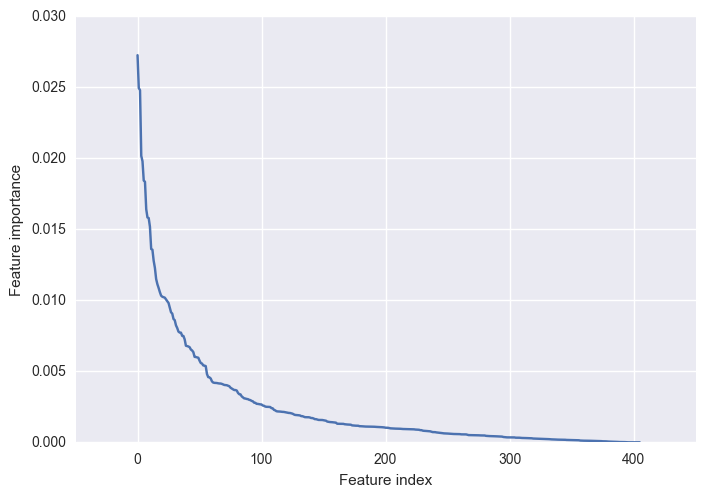

In [8]:
# plot feature importances
plt.figure()

plt.plot(feature_importances.values)

plt.xlim(-50, 450)

plt.ylabel('Feature importance')
plt.xlabel('Feature index')

plt.show()

### Classification performance

Finally, we can also see that adding more training data will result in an increase in performance. When sufficient training data is available, the training performance and cross-validated performance should somewhat converge to a similar score. Instead, here we can see that the training performance is very high indicating some extent of overfitting on the training data, while the cross-validated performance gradually increases in function of the size of the training data.

(For execution time considerations, here a random forest consisting of only 10 trees was employed.)

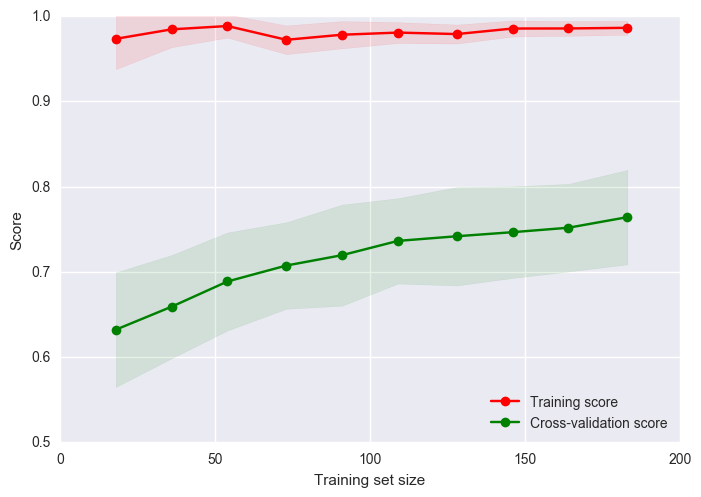

In [9]:
# cross validation with 100 iterations to get smoother mean test and train score curves
cv = cross_validation.StratifiedShuffleSplit(y, n_iter=100, test_size=0.2, random_state=0)
estimator = ensemble.RandomForestClassifier(10, n_jobs=-1, random_state=0)

plt.figure()

# compute the learning curves
train_sizes, train_scores, test_scores = learning_curve.learning_curve(
    estimator, X, y, np.linspace(.1, 1.0, 10), cv, 'accuracy', n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot the learning curves
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.xlabel('Training set size')
plt.ylabel('Score')

plt.ylim(0.5, 1)

plt.legend(loc='lower right')

plt.show()